In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

In [3]:
import os
import sys

In [4]:
# chaging directory

In [5]:
root, *_ = !pwd

In [6]:
if root.endswith('notebooks'):
    os.chdir('../')
    root, *_ = !pwd
    sys.path.append('src/')

In [7]:
os.getcwd()

'/home/med/projects/competitions/mlb-kaggle'

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
RAW_PATH = Path(os.environ['RAW_PATH'])

In [10]:
PROCESSED_PATH = Path(os.environ['ROOT_DIR']) / 'processed'

In [11]:
os.listdir(RAW_PATH)

['seasons.csv',
 'teams.csv',
 'example_sample_submission.csv',
 'train_updated.csv',
 'train.csv',
 'mlb-player-digital-engagement-forecasting.zip',
 'awards.csv',
 'players.csv',
 'example_test.csv',
 'mlb',
 'train_updated.csv.zip']

In [12]:
os.listdir(PROCESSED_PATH)

['target.csv', 'context_raw_data.csv', 'raw_data.csv']

In [13]:
dates_cols = ['date', 'mlbDebutDate', 'DOB', 'rosterDate', 'pstatsDate']

In [14]:
df = pd.read_csv(PROCESSED_PATH / 'raw_data.csv',
                 parse_dates=dates_cols)

### players data

In [15]:
# not all players are in the private test set
# the players in the test set are saved in the players.csv file

In [16]:
_players = pd.read_csv(RAW_PATH / 'players.csv')

In [17]:
_players['playerForTestSetAndFuturePreds'].fillna(False, inplace=True)

In [18]:
player_in_test = _players.query('playerForTestSetAndFuturePreds')['playerId']

In [19]:
# player_in_test holds only the players in the test set

### filter players

In [20]:
from data.util import filter_by_date, filter_by_id

In [21]:
# # filter only test playersex
df = filter_by_id(df, player_in_test)

In [23]:
# if you want to run on a sample,
# change sample_size to the number of players in the sample
sample_size = None

In [24]:
if sample_size is not None and sample_size > 0:
    df['target_avg'] = df[[f'target{i}' for i in range(1, 5)]].mean(axis=1)
    playerList = df.groupby(['playerId'])['target_avg'].std().sort_values(ascending=False).reset_index()
    df = filter_by_id(df, playerList['playerId'].head(sample_size))
    df.drop('target_avg', axis=1, inplace=True)

In [25]:
df.playerId.nunique()

1187

In [26]:
df.head()

,playerId,target1,target2,target3,target4,date,home,positionName,pstatsDate,battingOrder,...,weekday,inSeason,seasonPart,DOB,mlbDebutDate,birthCountry,weight,primaryPositionName,height,playerBMI
0,405395,0.151872,21.449416,0.112952,22.990196,2018-01-01,NaN,NaN,NaT,NaN,...,0,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
1,405395,0.136406,10.978585,0.096403,15.669173,2018-01-02,NaN,NaN,NaT,NaN,...,1,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
2,405395,0.064460,9.226190,0.101464,23.172829,2018-01-03,NaN,NaN,NaT,NaN,...,2,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
3,405395,0.024217,10.170965,0.102448,35.359116,2018-01-04,NaN,NaN,NaT,NaN,...,3,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
4,405395,0.157556,4.294307,0.046517,12.347789,2018-01-05,NaN,NaN,NaT,NaN,...,4,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661


In [27]:
list(df.columns)

['playerId',
 'target1',
 'target2',
 'target3',
 'target4',
 'date',
 'home',
 'positionName',
 'pstatsDate',
 'battingOrder',
 'groundOuts',
 'runsScored',
 'homeRuns',
 'strikeOuts',
 'baseOnBalls',
 'intentionalWalks',
 'hits',
 'hitByPitch',
 'stolenBases',
 'groundIntoTriplePlay',
 'plateAppearances',
 'totalBases',
 'rbi',
 'catchersInterference',
 'pickoffs',
 'gamesPlayedPitching',
 'gamesStartedPitching',
 'completeGamesPitching',
 'winsPitching',
 'lossesPitching',
 'groundOutsPitching',
 'runsPitching',
 'strikeOutsPitching',
 'atBatsPitching',
 'caughtStealingPitching',
 'inningsPitched',
 'saveOpportunities',
 'battersFaced',
 'outsPitching',
 'balks',
 'pickoffsPitching',
 'gamesFinishedPitching',
 'inheritedRunners',
 'catchersInterferencePitching',
 'sacBuntsPitching',
 'saves',
 'holds',
 'blownSaves',
 'assists',
 'putOuts',
 'chances',
 'SLG',
 'runsScored__date__maxNorm',
 'homeRuns__date__maxNorm',
 'hits__date__maxNorm',
 'SLG__date__maxNorm',
 'rbi__date__maxNor

### cleaning dataset

In [28]:
def filter_by_idx(df, idx):
    return df.loc[idx, :].reset_index(drop=True)

In [29]:
## split train set
start_test_date = '2021-04-01'
end_test_date = '2021-08-01'

In [30]:
train_idx = df['date'] <= start_test_date

In [31]:
valid_idx = df['date'].between(start_test_date, end_test_date, inclusive=False)

In [32]:
raw_train_data = filter_by_idx(df, train_idx)

In [33]:
raw_valid_data = filter_by_idx(df, valid_idx)

In [34]:
# drop non game dates

In [35]:
# season_to_keep = ['Reg Season 1st Half', 'All-Star Break',
#        'Reg Season 2nd Half', 'Postseason']

### preprocessing 

In [36]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer
# from sklearn.compose import ColumnTransformer
# from pipeline.continuous import PdScaleNorm, FilterContinuousFeatures, MedianFillNaN
# from pipeline.stats import StatisticGen, LagGen, FeaturesTable
# from pipeline.categories import Categorify
# from pipeline.season import join_season_info
# from pipeline.players import join_players_info
# from pipeline.core import forward_fill, gen_hardcoded_features, fillna

In [37]:
target_cols = ['target1', 'target2', 'target3', 'target4']

####  categories 

In [38]:
from sklearn.preprocessing import OneHotEncoder

In [39]:
# categories encoding
categories = ['seasonPart', 'year',
              'primaryPositionName', 'status']
interaction_categories = ['playerId']

In [40]:
filter_cat_tmf = FunctionTransformer(lambda df: df.loc[:, categories])
filter_int_cat_tmf = FunctionTransformer(lambda df: df.loc[:, interaction_categories])

In [41]:
categories_pipeline = Pipeline([('filter', filter_cat_tmf),
                                 ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [42]:
interaction_categories_pipeline = Pipeline([('filter', filter_int_cat_tmf),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#### CONT FEATURES 

In [43]:
from sklearn.preprocessing import KBinsDiscretizer

In [44]:
CONT_FEATS = ['rbi', 'homeRuns']
filter_cont_tmf = FunctionTransformer(lambda df: df.loc[:, CONT_FEATS].fillna(-1))
cont_pipeline = Pipeline([('get_cont', filter_cont_tmf),
                         ('disc', KBinsDiscretizer(strategy='uniform'))])

### text 

In [45]:
filter_text = FunctionTransformer(lambda df: df.loc[:, 'description'])
fill_nan_text = FunctionTransformer(lambda df: df.fillna(''))

In [46]:
MAX_TEXT_FEATURES = 25000

In [47]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [48]:
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

In [49]:
text_to_tokens_tmf = HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC, norm=None, binary=False,
                  ngram_range=(1, 2),
                  n_features=MAX_TEXT_FEATURES)
text_to_tokens_tmf = TfidfVectorizer()

In [50]:
text_pipeline = Pipeline([('get_text', filter_text),
                          ('fillnan', fill_nan_text),
                          ('text_to_tokens', text_to_tokens_tmf)])

In [51]:
## putting everything together

In [52]:
from sklearn.preprocessing import MaxAbsScaler

In [53]:
from itertools import combinations

import numpy as np
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin


class SparseInteractions(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2, feature_name_separator="_"):
        self.degree = degree
        self.feature_name_separator = feature_name_separator

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not sparse.isspmatrix_csc(X):
            X = sparse.csc_matrix(X)

        if hasattr(X, "columns"):
            self.orig_col_names = X.columns
        else:
            self.orig_col_names = np.array([str(i) for i in range(X.shape[1])])

        spi = self._create_sparse_interactions(X)
        return spi

    def get_feature_names(self):
        return self.feature_names

    def _create_sparse_interactions(self, X):
        out_mat = []
        self.feature_names = self.orig_col_names.tolist()

        for sub_degree in range(2, self.degree + 1):
            for col_ixs in combinations(range(X.shape[1]), sub_degree):
                # add name for new column
                name = self.feature_name_separator.join(self.orig_col_names[list(col_ixs)])
                self.feature_names.append(name)

                # get column multiplications value
                out = X[:, col_ixs[0]]
                for j in col_ixs[1:]:
                    out = out.multiply(X[:, j])

                out_mat.append(out)

        return sparse.hstack([X] + out_mat)

In [55]:
interaction_feature_tmf = Pipeline([('union', FeatureUnion([('conts', filter_cont_tmf), 
                                                            ('cats', interaction_categories_pipeline)])),
                                    ('int', SparseInteractions())])

In [56]:
join_feature_tmf = FeatureUnion([('int', interaction_feature_tmf),  ('cats', categories_pipeline)])

In [57]:
pipeline = Pipeline([('gen_features', join_feature_tmf),
                     ('scale', MaxAbsScaler())])

In [58]:
train_features = pipeline.fit_transform(raw_train_data)

In [59]:
valid_features = pipeline.transform(raw_valid_data)

In [60]:
train_features

<1408969x707489 sparse matrix of type '<class 'numpy.float64'>'
	with 13556582 stored elements in Compressed Sparse Row format>

In [118]:
# checking for nans
for i in range(train_features.shape[1]):
    assert not np.isnan(train_features[:, i].toarray()).any(), i

In [61]:
from sklearn.linear_model import Lasso

In [ ]:
models = []
for target_name in target_cols:
    print(target_name)
    _model = Lasso(alpha=0.5, max_iter=5000)
    _model.fit(train_features, raw_train_data[target_name])
    models.append(_model)
    

In [ ]:
_prediction = np.stack([_model.predict(valid_features)
                       for _model in models], axis=1)

In [ ]:
prediction = pd.DataFrame(_prediction, columns=['yhat1', 'yhat2', 'yhat3', 'yhat4'])

In [126]:
prediction[['playerId', 'date'] + target_cols] = raw_valid_data[['playerId', 'date'] + target_cols]

In [127]:
from evaluate.metrics import compute_metrics

In [128]:
# metrics from 2021-03-01 up to 2021-04-30
compute_metrics(prediction)

{'mae_mean': 15.433645629430625,
 'mae_1': 12.872834587137042,
 'mae_2': 15.290851633909504,
 'mae_3': 15.932046302222211,
 'mae_4': 17.63884999445374}

In [129]:
(prediction.groupby(prediction.date.dt.month)
 .apply(lambda x: pd.Series(compute_metrics(x))))

,mae_mean,mae_1,mae_2,mae_3,mae_4
date,,,,,
4,14.378704,12.894048,13.135239,15.370453,16.115075
5,14.546196,12.587132,14.477535,15.006523,16.113595
6,15.612773,12.024787,16.416523,16.256737,17.753044
7,18.535435,14.854188,18.464700,18.004793,22.818059


In [130]:
(prediction.groupby(['playerId'])
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False))

,mae_mean,mae_1,mae_2,mae_3,mae_4
playerId,,,,,
660271,34.836763,23.864115,40.038838,35.353512,40.090586
592450,17.687773,18.759482,13.652305,18.316526,20.022780
665487,17.046371,14.764062,14.174703,19.502089,19.744629
519317,15.560564,16.328872,13.137467,16.621456,16.154460
547180,13.908548,11.095555,14.265136,14.352415,15.921085
545361,13.124114,7.930848,14.125159,12.565675,17.874774
605141,12.869198,11.541969,11.198086,14.851264,13.885474
543037,10.335496,9.386669,13.137178,9.172121,9.646015
592885,9.574226,7.356058,9.663195,7.829272,13.448381


In [131]:
hardest_id = filter_by_id(prediction, [660271])

In [132]:
(hardest_id.groupby(['playerId', hardest_id.date.dt.month])
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False))

mae_mean      mae_1      mae_2      mae_3      mae_4
playerId date                                                       
660271   7     63.322640  49.815994  61.081219  64.348330  78.045016
         6     34.647820  18.499064  42.937178  33.886074  43.268963
         5     29.147935  20.639203  38.826668  29.168867  27.957002
         4     24.414764  17.648319  26.001133  26.485763  27.523843

In [133]:
# # metrics from 2021-03-01 up to 2021-04-30
# compute_metrics(recursive_prediction)

In [134]:
# # metrics from 2021-03-01 up to 2021-03-31
# compute_metrics(valid_rc_prediction)

In [135]:
# # metrics from 2021-04-01 up to 2021-04-30
# compute_metrics(test_rc_prediction)

In [136]:
def plot_pred(df, playerId, index=1):
    pdf = df.query(f'playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    yhat_name = f'yhat{index}'
    
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    ax.plot('date', yhat_name, '-o', data=pdf, label=tname)
    
    ax.legend()
    

def plot_feature_vs_target(df, feature, playerId, index=1):
    pdf = df.query(f'raw_playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    twinx = ax.twinx()
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    twinx.plot('date', feature, '-o', data=pdf, label=feature, color='red')
    twinx.legend()
    ax.set_title(f'{tname} vs {feature}')
    

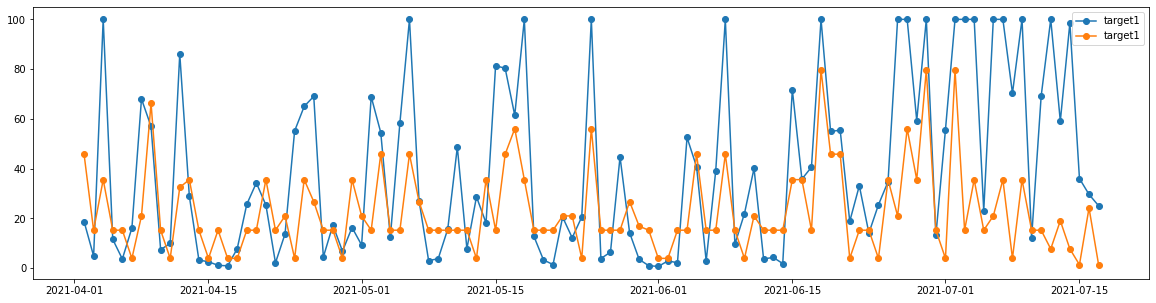

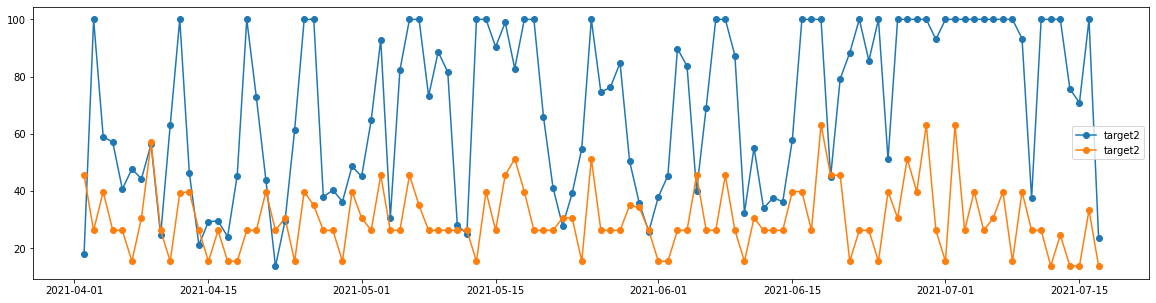

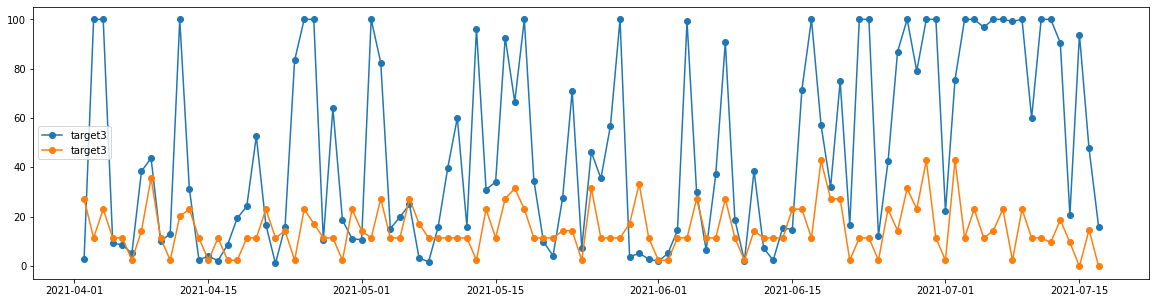

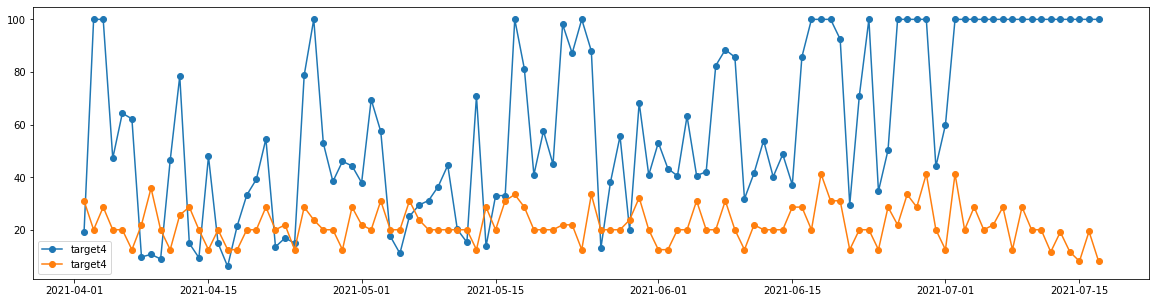

In [137]:
for index in range(1, 5):
    plot_pred(hardest_id, playerId=660271, index=index)

In [94]:
import numpy as np
import pandas as pd


def permutation_importance(predict_fn, data,
                           features,
                           target,
                           score_func,
                           times: int = 1):

    def _score(data):
        _prediction = predict_fn(data)
        prediction = data[target].copy()
        prediction[['yhat1', 'yhat2', 'yhat3', 'yhat4']] = _prediction
        error = score_func(prediction)
        return error['mae_mean']

    base_score = _score(data)
    fi = []

    for feature in features:
        permuted_data = data.copy()
        permuted_data[feature] = np.random.permutation(permuted_data[feature])
        feature_score = _score(permuted_data)
        feature_importance = {'feature': feature,
                              'score': feature_score,
                              'importance': feature_score-base_score,
                              }
        fi.append(feature_importance)
    fi = pd.DataFrame(fi)
    fi['importance'] *= 100
    fi.sort_values(by='importance', inplace=True, ascending=False)
    fi.reset_index(drop=True, inplace=True)
    return fi

In [95]:
fi_data = valid_data

NameError: name 'valid_data' is not defined

In [ ]:
fi_data = train_data.sample(frac=0.2).reset_index(drop=True)

In [ ]:
all_features_list = list(features.columns)

In [ ]:
%%time
fi_reg = permutation_importance(output.predict_fn, valid_data, 
                                all_features_list, target=target_cols, 
                                score_func=compute_metrics,
                                times=5)

In [ ]:
fi_reg

In [ ]:
valid_data['raw_playerId'] = raw_valid_df['playerId']

In [ ]:
for index in range(1, 5):
    plot_feature_vs_target(valid_data, 'playerTeamoutsPitching__date__maxNorm', playerId=660271, index=index)

In [ ]:
output_path = 'prediction/drop_lstm'
os.makedirs(output_path, exist_ok=True)

In [ ]:
# valid_test_prediction.to_csv(os.path.join(output_path, 'april_to_jul.csv'), index=False)